In [57]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

In [58]:
runname = "default"
@inline function makestreamfuncvid(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    shearfilename = "shear_production.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    function ψᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        aᶠᶜᶜ = cumsum(uᶠᶜᶜ .* Δzᵃᵃᶜ; dims=3)

        bᶜᶜᶠ = cumsum(wᶜᶜᶠ .* Δx; dims=1)
        aᶜᶜᶜ = (circshift(aᶠᶜᶜ, (-1, 0)) .+ aᶠᶜᶜ) / 2
        bᶜᶜᶜ = (bᶜᶜᶠ[:, 1:end-1] .+ bᶜᶜᶠ[:, 2:end]) ./ 2
        return -aᶜᶜᶜ .+ bᶜᶜᶜ
    end

    file = jldopen("$foldername/$filename")
    shearfile = jldopen("$foldername/$shearfilename")

    n = Observable(101)

    frame = @lift frames[$n]


    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    v = @lift file["timeseries/v_dfm/$($frame)"][:, 1, :]

    u = @lift file["timeseries/u_dfm/$($frame)"][:, 1, :]
    w = @lift file["timeseries/w_dfm/$($frame)"][:, 1, :]

    b = @lift file["timeseries/b_dfm/$($frame)"][:, 1, :]
    
    LSP = @lift shearfile["timeseries/LSP/$($frame)"][:, 1, :]
    GSP = @lift (shearfile["timeseries/GSP/$($frame)"][:, 1, 1:end-1] + shearfile["timeseries/GSP/$($frame)"][:, 1, 2:end]) / 2
    BFLUX = @lift (shearfile["timeseries/BFLUX/$($frame)"][:, 1, 1:end-1] + shearfile["timeseries/BFLUX/$($frame)"][:, 1, 2:end]) / 2
    
    # Get the secondary cirulation streamfunction
    σ=3
    ψ = @lift imfilter(ψᶜᶜᶜ($u, $w, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ), gaussian((σ, 0), (4σ+1, 5)), "circular")

    title = @lift "t = $(round(ts[$n]; digits=2))"
    
    axis_kwargs = (; xlabel="x", ylabel="z", limits=(-2.5, 2.5, -0.15, 0))

    fig = Figure(resolution=(2000, 600))
    fig[1, 1:5] = Label(fig, title, fontsize=20)
    axBFLUX = Axis(fig[2, 1]; title="BFLUX", axis_kwargs...)
    axLSP = Axis(fig[2, 3]; title="LSP", axis_kwargs...)
    axGSP = Axis(fig[2, 4]; title="GSP", axis_kwargs...)
    
    ht1 = heatmap!(axBFLUX, xᶜᵃᵃ, zᵃᵃᶜ, BFLUX; colormap=:balance, colorrange=(-1e-2, 1e-2))
    
    ht2 = heatmap!(axLSP, xᶜᵃᵃ, zᵃᵃᶜ, LSP; colormap=:balance, colorrange=(-1e-4, 1e-4))
    heatmap!(axGSP, xᶜᵃᵃ, zᵃᵃᶜ, GSP; colormap=:balance, colorrange=(-1e-4, 1e-4))
    for ax in [axBFLUX, axLSP, axGSP]
        contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, ψ; colormap=:BrBG_10, levels=range(-0.004, 0.004, 16), alpha=1, linewidth=2)
        contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, b; color=(:black, 0.5), levels=range(-300, -100, 30), linewidth=1.5)
    end
    Colorbar(fig[2, 5], ht2, label="Energy flux")
    Colorbar(fig[2, 2], ht1, label="Energy flux")
    vidfoldername = "output/videos/$runname/shearproduction"
    !ispath(vidfoldername) && mkpath(vidfoldername)
    w = ZipFile.Writer("$vidfoldername.zip");
    for i in 101:length(frames)
        n[] = i
        zipfile = ZipFile.addfile(w, "$(lpad(i, 4, '0')).png");
        save("$vidfoldername/$(lpad(i, 4, '0')).png", fig)
        open(r -> write(zipfile, r), "$vidfoldername/$(lpad(i, 4, '0')).png")
        close(zipfile)
        rm("$vidfoldername/$(lpad(i, 4, '0')).png")
    end
    close(file)
    rm("$vidfoldername")
    close(w)
    fig
end
makestreamfuncvid("ShearProductionRi025")

LoadError: KeyError: key "6072" not found

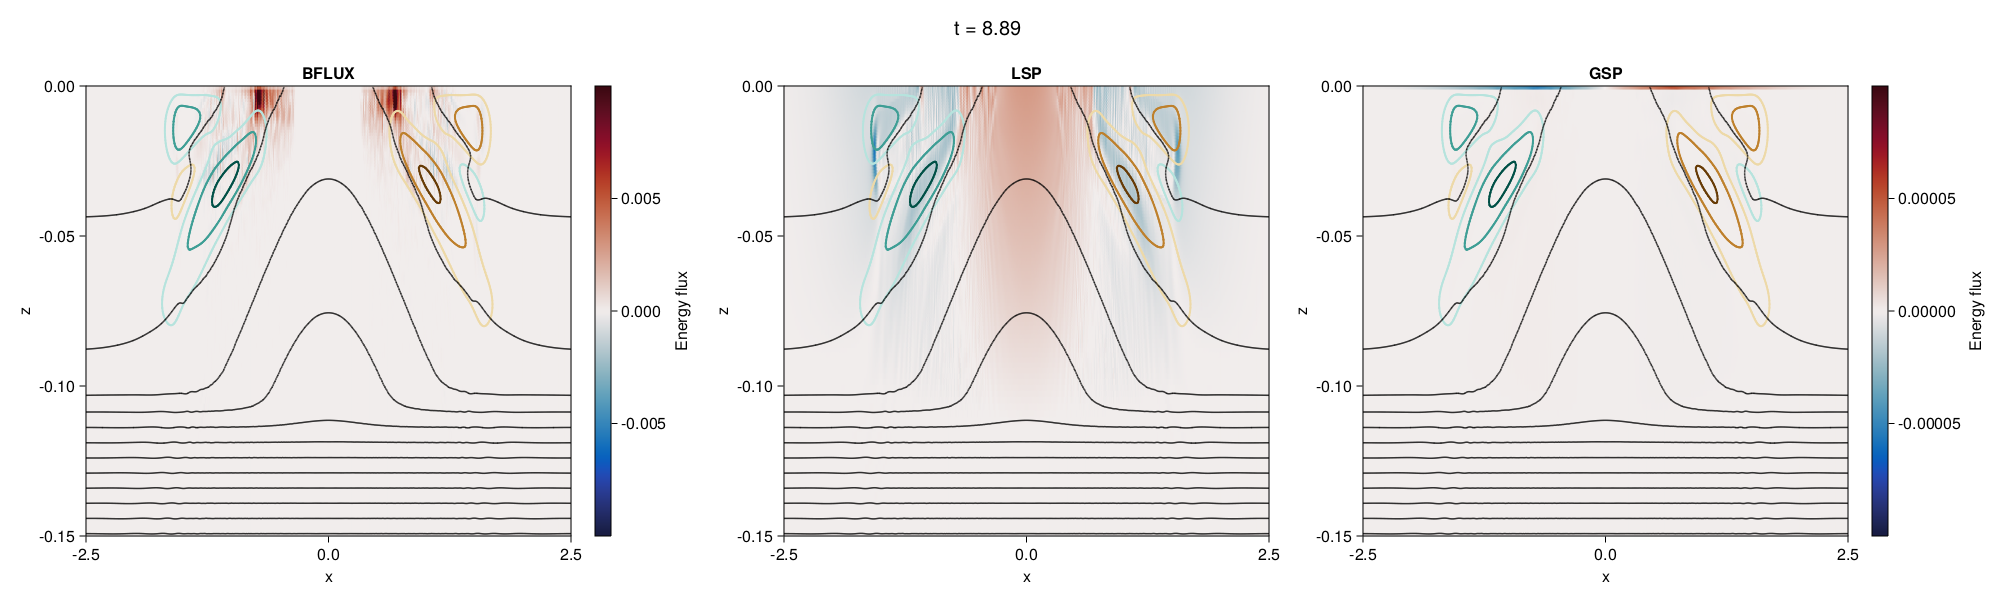

In [59]:
makestreamfuncvid("ShearProductionRi01")
makestreamfuncvid("ShearProductionRi06")
makestreamfuncvid("ShearProductionRi1")